# Model selection

In [1]:
using Revise

In [2]:
using RxInfer, Distributions, Random, PyPlot

### Data generation

In [3]:
# specify distribution
dist = MixtureModel(Normal, [(-2.0, 1.0), (0.0, 1.0), (3.0, 1.0)], [0.2, 0.5, 0.3]);

In [4]:
function generate_data(dist, nr_samples; rng=MersenneTwister(123))

    # sample from distribution
    samples = rand(rng, dist, nr_samples)

    # return samples
    return samples

end;

In [5]:
data = generate_data(dist, 100);

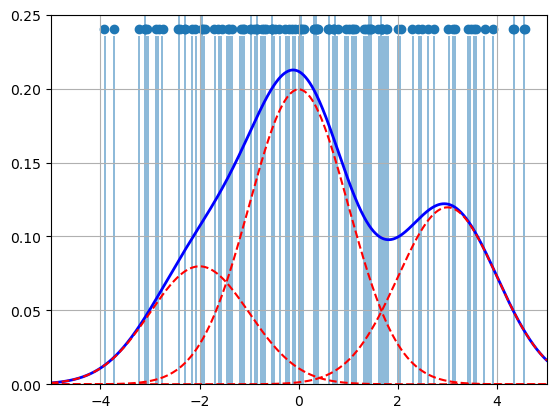

(0.0, 0.25)

In [6]:
plt.plot(-5:0.01:5, map(x -> pdf(dist, x), -5:0.01:5), color="blue", linewidth=2)
plt.hist(data, density="relative", bins=200, alpha=0.5)
plt.plot(-5:0.01:5, map(x -> dist.prior.p[1]*pdf(dist.components[1], x), -5:0.01:5), color="red", linestyle="--")
plt.plot(-5:0.01:5, map(x -> dist.prior.p[2]*pdf(dist.components[2], x), -5:0.01:5), color="red", linestyle="--")
plt.plot(-5:0.01:5, map(x -> dist.prior.p[3]*pdf(dist.components[3], x), -5:0.01:5), color="red", linestyle="--")
plt.scatter(data, 0.24*ones(length(data)))
plt.grid()
plt.xlim(-5, 5)
plt.ylim(0, 0.25)

In [7]:
@model function model_selection(nr_samples)

    # specify experimental outcomes
    y = datavar(Float64, nr_samples)
    θ = randomvar(nr_samples)
    θ1 = randomvar(nr_samples)
    θ2 = randomvar(nr_samples)
    θ3 = randomvar(nr_samples)
    z = randomvar(nr_samples)



    # create likelihood models
    for i in 1:nr_samples

        # specify John's and Jane's prior models over θ
        θ1[i] ~ NormalMeanPrecision(-2, 100)
        θ2[i] ~ NormalMeanPrecision(0, 100)
        θ3[i] ~ NormalMeanPrecision(3, 100)

        # specify initial guess as to who is right
        z[i] ~ Categorical([0.2, 0.5, 0.3])

        # specify mixture prior Distribution
        θ[i] ~ Switch(z[i], (θ1[i], θ2[i], θ3[i])) where { pipeline = RequireMarginal(switch) }

        # specify observatio noise
        y[i] ~ NormalMeanPrecision(θ[i], 1.0)
        
    end

    return y, θ, θ1, θ2, θ3, z

end

In [8]:
@constraints function constraints_selection()
    q(z) :: PointMass
end

constraints_selection (generic function with 1 method)

In [9]:
results_selection = inference(
    model = model_selection(100),
    constraints = constraints_selection(),
    data  = (y = data, ),
    returnvars = (θ = KeepLast(), θ1 = KeepLast(), θ2 = KeepLast(), θ3 = KeepLast(), z=KeepLast()),
    options = ( addons = (AddonLogScale(),), )
)

Inference results:
  Posteriors       | available for (θ1, θ3, θ2, z, θ)


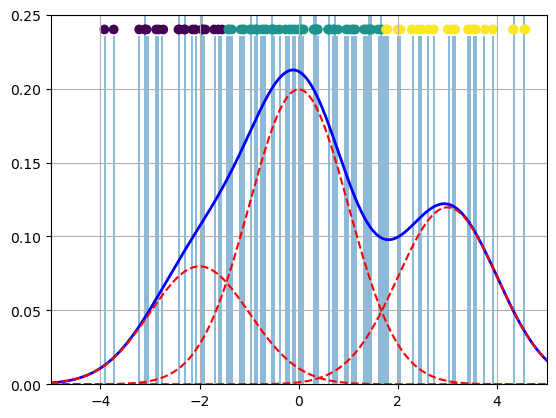

(0.0, 0.25)

In [10]:
plt.plot(-5:0.01:5, map(x -> pdf(dist, x), -5:0.01:5), color="blue", linewidth=2)
plt.hist(data, density="relative", bins=200, alpha=0.5)
plt.plot(-5:0.01:5, map(x -> dist.prior.p[1]*pdf(dist.components[1], x), -5:0.01:5), color="red", linestyle="--")
plt.plot(-5:0.01:5, map(x -> dist.prior.p[2]*pdf(dist.components[2], x), -5:0.01:5), color="red", linestyle="--")
plt.plot(-5:0.01:5, map(x -> dist.prior.p[3]*pdf(dist.components[3], x), -5:0.01:5), color="red", linestyle="--")
plt.scatter(data, 0.24*ones(length(data)), c=argmax.(mean.(results_selection.posteriors[:z])))
plt.grid()
plt.xlim(-5, 5)
plt.ylim(0, 0.25)